# Person - forecasting

The purpose here is to generate the most accurate hourly forecast given a set of data points with collected and engineered features.

In [18]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

### Load dataset

In [70]:
df = pd.read_csv('../Datasets/Person_no_outliers_feature_eng__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4079, 13)


,date,hour,obs_count,n_month,n_week_in_month,is_weekend_day,cur__precipIntensity,cur_weather_type,cur__windSpeed,cur__windGust,gust_strength,daily__sunriseTime,daily__sunsetTime
0,2019-09-09,0,0,9,2,0,0.7929,Bad,21.30,35.13,Low,1568008740,1568055900
1,2019-09-09,1,0,9,2,0,0.8310,Bad,22.49,35.87,Low,1568008740,1568055900


### Filter out nightly hours

Based on the current data collection and specifically a lack of night vision camera, there is no need to include night-time observations in the forecast generation as these will be set to 0 and they would be too easy to get correctly.

We can use the daily sunrise and sunset time to exclude only relevant data points, instead of blindly removing too much data.

In [72]:
# convert timestamps to hours
conv_ts = lambda x: datetime.fromtimestamp(x).hour
df['sunrise_hour'] = df['daily__sunriseTime'].apply(conv_ts)
df['sunset_hour'] = df['daily__sunsetTime'].apply(conv_ts)

In [76]:
# remove nightly records
idx = (df['hour'] < df['sunrise_hour']) | (df['hour'] > df['sunset_hour'])
df = df.loc[~idx]

### Discuss approach

Firstly create a crude model, which will use hourly averages to generate forecast

In [81]:
# create a train/test split for the dataset
X, y = df[['hour', 'obs_count']], df['obs_count']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=41)

In [82]:
# calculate hourly averages of counts for training set
mean_obj_counts = X_train.groupby('hour')['obs_count'].mean()

In [83]:
# now we can generate the predictions for the test set
y_pred = X_test['hour'].map(mean_obj_counts)

In [96]:
# round results to 
y_pred_rounded = [round(p) for p in y_pred]

In [122]:
# calculate mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

3.284901486206795
1.3845331916865935
0.005539358758843038


Even though metrics like mean squared error, absolute error or r2 score are there to help us, the main question is: **How bad the error is and what do we consider a good forecast?**

For this I am proposing a simple heuristic below, where an absolute error is calculated as follows:

$$error=abs(y\_test-y\_pred)$$

This error can be then plotted as a histogram and we can make a conclusion about which model actually predicts the best results by looking at the number of errors, which we obviously want to minimise.

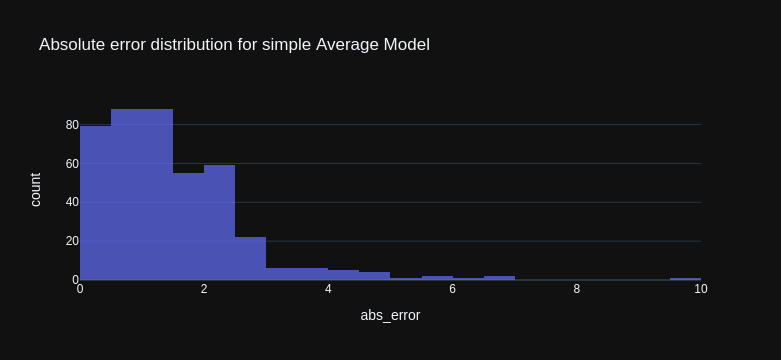

In [127]:
# calculate absolute error and plot a histogram
X_test_cp = X_test.copy()
X_test_cp['predicted'] = y_pred
X_test_cp['abs_error'] = (X_test_cp['obs_count'] - X_test_cp['predicted']).abs()
idx = X_test_cp['abs_error'] > 0.1
px.histogram(X_test_cp[idx], x="abs_error", opacity=0.7, height=300,
             title='Absolute error distribution for simple Average Model')